# gwexpy.fitting: iminuit ベースのフィッティング機能

このノートブックでは、`gwexpy.fitting` モジュールを使用して、`TimeSeries` や `FrequencySeries` データに対して簡単にフィッティングを行う方法を紹介します。
バックエンドには `iminuit` を使用しており、誤差を考慮した最小二乗法フィッティングが可能です。

In [1]:
##import warnings
#warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import numpy as np
import matplotlib.pyplot as plt
from gwexpy.timeseries import TimeSeries
from gwexpy.frequencyseries import FrequencySeries
from gwexpy.plot import Plot
plt.rcParams['figure.figsize'] = (10, 6)

## 1. データの準備

ここでは、ガウス関数にノイズを加えたダミーデータを作成します。

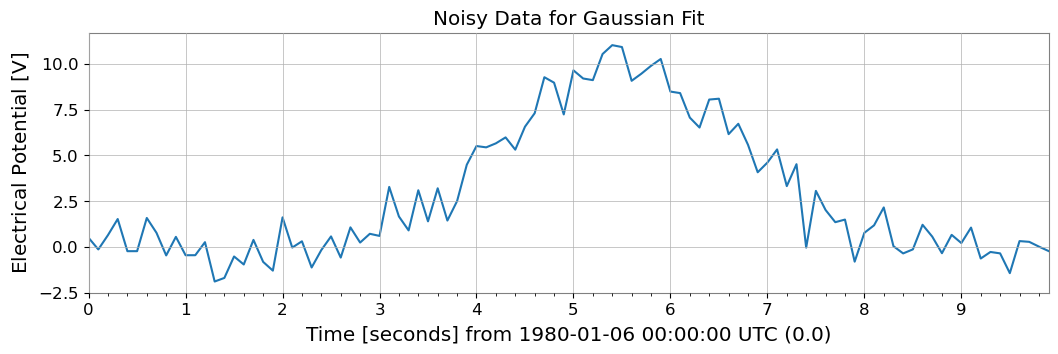

In [2]:
# モデル関数の定義 (ガウス関数)
def gaussian(x, a, mu, sigma):
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2))

# ダミーデータの生成
np.random.seed(42)
x = np.linspace(-5, 5, 100)
true_params = {'a': 10, 'mu': 0.5, 'sigma': 1.2}
y_true = gaussian(x, **true_params)
y_noise = y_true + np.random.normal(0, 1.0, size=len(x))

# TimeSeries オブジェクトの作成
ts = TimeSeries(y_noise, dt=0.1, name='Noisy Gaussian', unit='V')
ts.plot(title='Noisy Data for Gaussian Fit');

## 2. フィッティングの実行

`ts.fit()` メソッドを使用してフィッティングを行います。
引数にはモデル関数と、パラメータの初期値 `p0` を指定します。

In [3]:
# フィッティング
# p0 で初期値を指定します
result = ts.fit(gaussian, sigma=0.8, p0={'a': 5, 'mu': 5, 'sigma': 1})

# 結果の表示
display(result)

/home/washimi/work/gwexpy/gwexpy/fitting/core.py:69: VisibleDeprecationWarning: make_func_code is deprecated: Use of ``func_code`` attribute to declare parameters is deprecated. Use ``_parameters`` instead, which is a dict of parameter names to limits.
  self.func_code = make_func_code(params)


## 3. 結果の取得とプロット

`FitResult` オブジェクトから、ベストフィットパラメータや誤差、Chi2 値などを取得できます。
また、`.plot()` メソッドで簡単に結果を可視化できます。

Best Fit Parameters: {'a': 10.052918089639567, 'mu': 5.494564817596109, 'sigma': 1.1593703774717468}
Errors: {'a': 0.21465022756078286, 'mu': 0.028783389076541727, 'sigma': 0.028181477959482414}
Chi2: 125.15392927134543
NDOF: 97


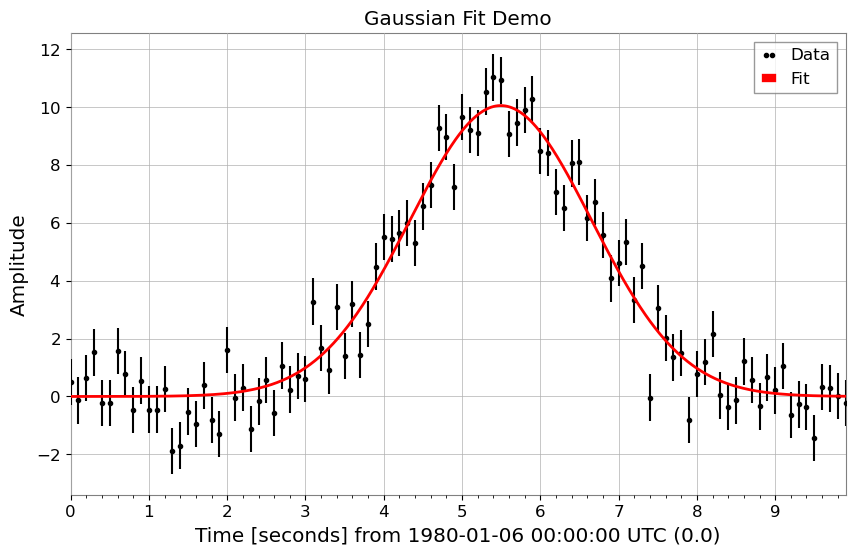

In [4]:
print("Best Fit Parameters:", result.params)
print("Errors:", result.errors)
print("Chi2:", result.chi2)
print("NDOF:", result.ndof)

# プロット
fig, ax = plt.subplots(figsize=(10, 6))
result.plot(ax=ax, color='red', linewidth=2)
ax.set_title("Gaussian Fit Demo")
# auto-gps を使う場合は、xlabel は GWpy に任せる（epoch を含むラベルになる）
ax.set_ylabel("Amplitude")
plt.show()

## 3. 文字列によるモデル指定

モデル関数を定義する代わりに、定義済みのモデル名を文字列で指定することもできます。
現在サポートされているモデル: `'gaus'`, `'exp'`, `'pol0'`, `'pol1'`, ... `'pol9'`, `'landau'` など。

以下は `'gaus'` を指定してフィッティングを行う例です。

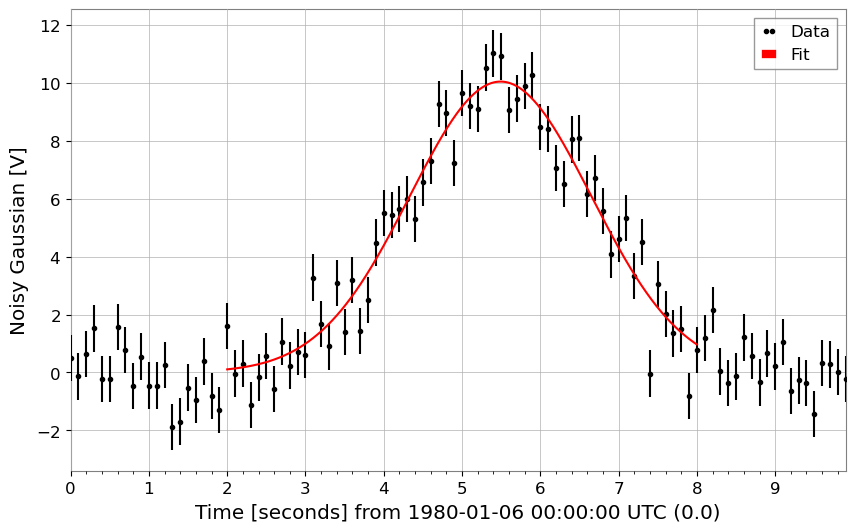

In [5]:
# 文字列 'gaus' を指定してフィッティング
# 注意: 定義済みモデルのパラメータ名はモデルごとに決まっています (Gaussianの場合は A, mu, sigma)
result_str = ts.fit('gaus', 
                    p0={'A': 10, 'mu': 5, 'sigma': 1.0}, 
                    x_range=(2, 8),
                    sigma=0.8
                   )

# 結果の表示
display(result_str)
result_str.plot();

## 4. 複素数フィッティング (伝達関数)

伝達関数などの複素数データに対してもフィッティングを行えます。
コスト関数として $\chi^2 = \sum (Re_{diff})^2 + \sum (Im_{diff})^2$ を最小化し、実部と虚部を同時にフィットします。
結果のプロットは自動的にボード線図（振幅・位相）になります。

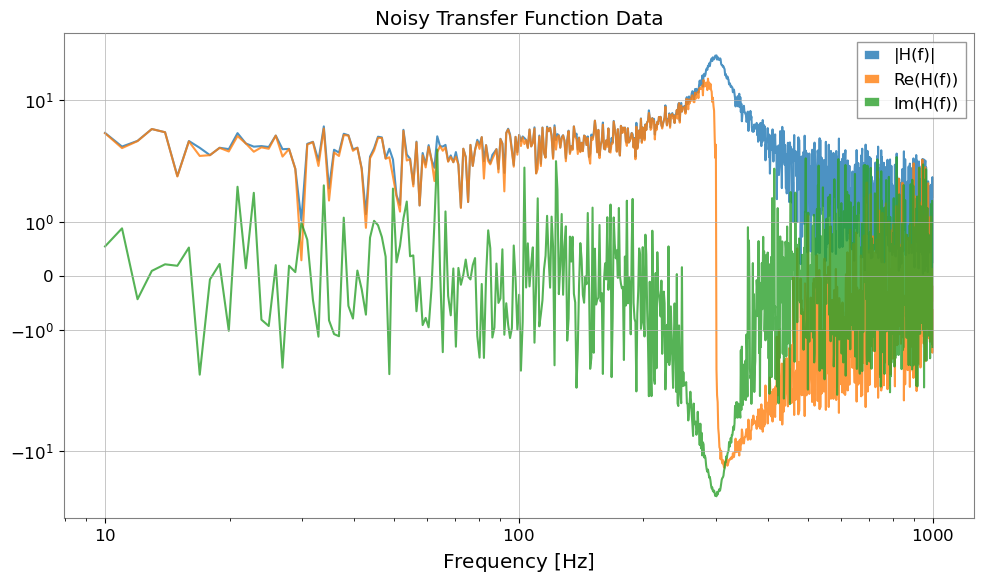

In [ ]:
# 1. 複素数モデルの定義 (単純な極)
def pole_model(f, A, f0, Q):
    # H(f) = A / (1 + i * Q * (f/f0 - f0/f))
    # Low-pass filter like but simplified. Let's use standard mechanical transfer function:
    # H(f) = A / [ (f0^2 - f^2) + i * (f0 * f / Q) ]
    omega = 2 * np.pi * f
    omega0 = 2 * np.pi * f0
    return A / ( (omega0**2 - omega**2) + 1j * (omega0 * omega / Q) )

# 2. データ生成
f = np.linspace(10, 1000, 1000)
p_true = {'A': 1e7, 'f0': 300, 'Q': 10}
data_clean = pole_model(f, **p_true)

# ノイズ付加 (実部・虚部独立)
np.random.seed(0)
noise_re = np.random.normal(0, 5, len(f))
noise_im = np.random.normal(0, 5, len(f))
data_noisy = data_clean + 0.2*noise_re + 0.2j * noise_im

# FrequencySeries 作成
fs = FrequencySeries(data_noisy, frequencies=f, name='Transfer Function')
plot = Plot(fs.abs(), fs.real, fs.imag, xscale='log', yscale='symlog', alpha=0.8)
plt.legend(['|H(f)|','Re(H(f))','Im(H(f))'])
plt.title('Noisy Transfer Function Data')
plt.tight_layout()
plt.show()

Fit Start...


/home/washimi/work/gwexpy/gwexpy/fitting/core.py:32: VisibleDeprecationWarning: make_func_code is deprecated: Use of ``func_code`` attribute to declare parameters is deprecated. Use ``_parameters`` instead, which is a dict of parameter names to limits.
  self.func_code = make_func_code(params)


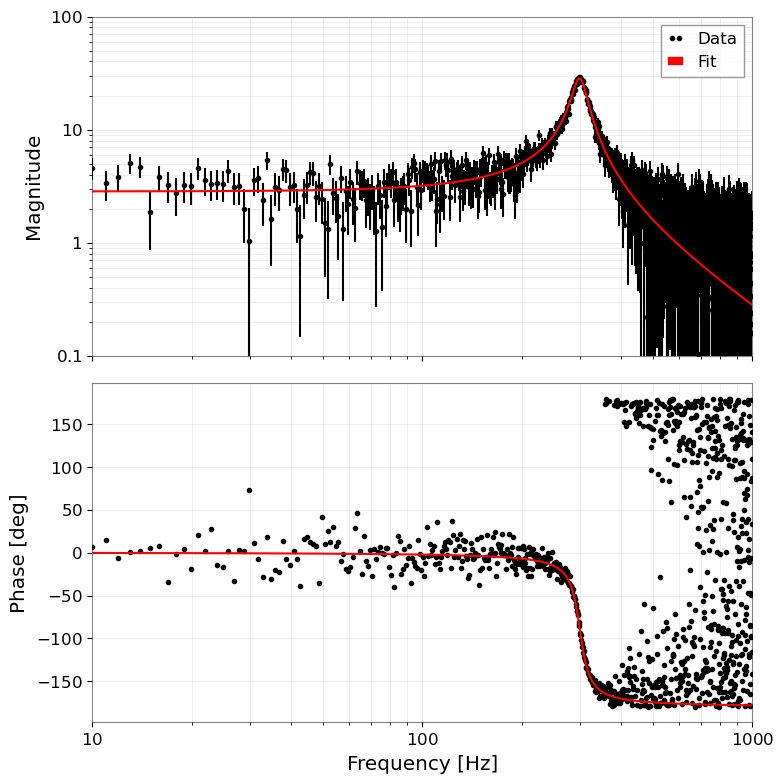

In [7]:
# 3. フィッティング
print("Fit Start...")
# 初期値はずらしておく
result_complex = fs.fit(pole_model, sigma=1.0,
                        p0={'A': 0.8e7, 'f0': 320, 'Q': 8})

# 結果表示
display(result_complex)

# 4. プロット (ボード線図)
# 自動的に振幅と位相のプロットになります
result_complex.bode_plot()
plt.gcf().get_axes()[0].set_ylim(1e-1,1e2)
plt.tight_layout()
plt.show()

## 5. MCMC 解析 (emcee)

`iminuit` で得られた最尤推定値を初期値として、`emcee` を用いた MCMC (Markov Chain Monte Carlo) 解析を行うことができます。

> **Note:** この機能を使用するには `emcee` と `corner` がインストールされている必要があります。

100%|██████████| 1000/1000 [00:01<00:00, 534.13it/s]


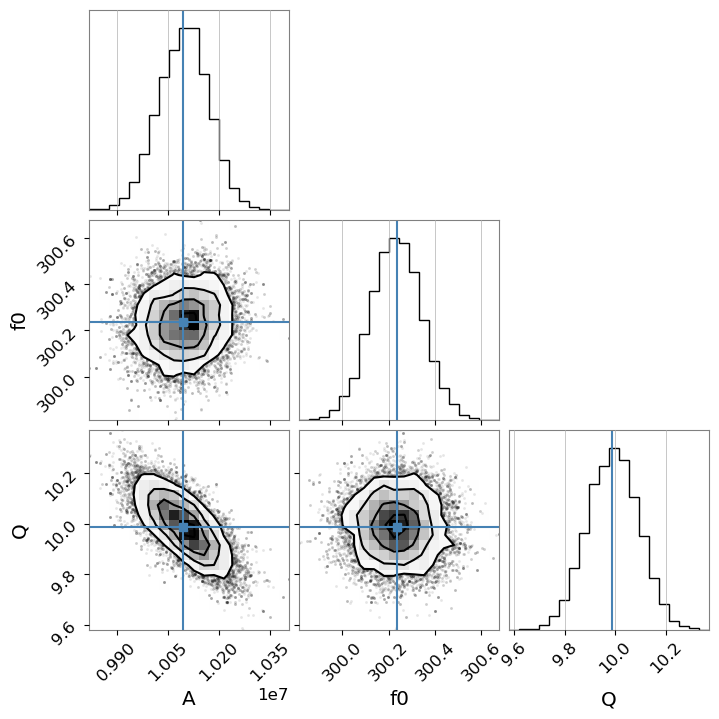

In [8]:
# MCMCの実行
# n_walkers: walkerの数, n_steps: ステップ数, burn_in: 捨て去る初期ステップ数
try:
    sampler = result_complex.run_mcmc(n_walkers=32, n_steps=1000, burn_in=200)
    
    # コーナープロットの作成 (事後分布の可視化)
    # 真値（または最尤推定値）を青線で表示します
    result_complex.plot_corner()
    
except ImportError as e:
    print(e)
except Exception as e:
    print(f"MCMC Error: {e}")

## 新しい共通モデルの使用例

`gwexpy.fitting.models` に追加された `power_law` と `damped_oscillation` の使用例です。

Power law alpha: -1.5073254489038617


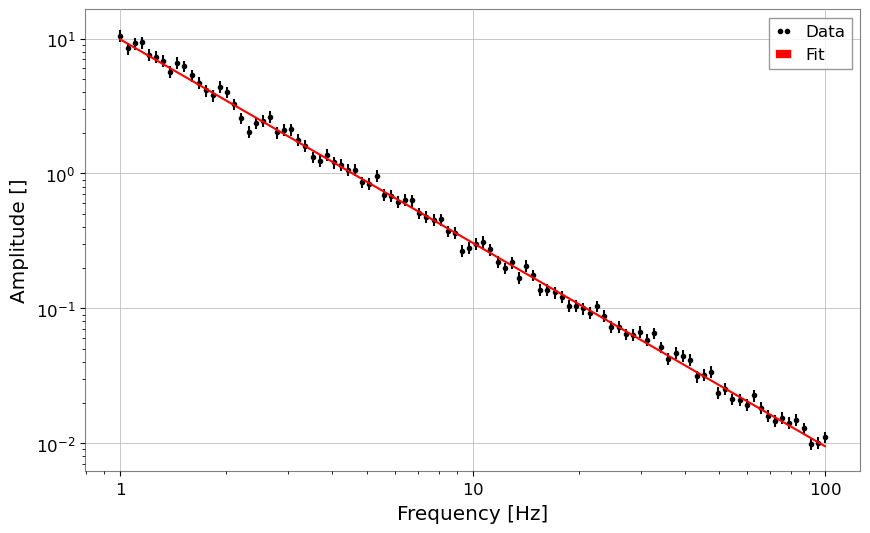

Damped oscillation frequency: 9.993425925552767


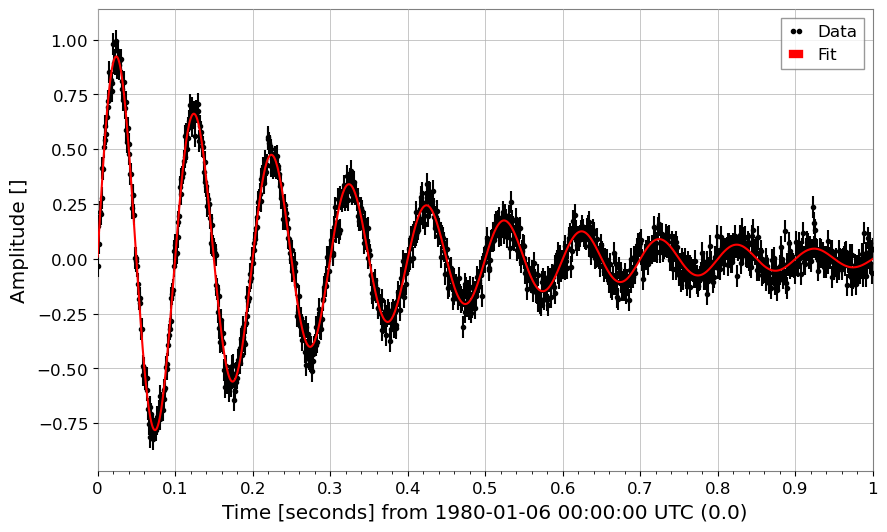

In [9]:
from gwexpy.fitting.models import power_law, damped_oscillation

# Power law
x = np.logspace(0, 2, 100)
y = power_law(x, A=10, alpha=-1.5) * (1 + 0.1 * np.random.normal(size=len(x)))
fs = FrequencySeries(y, frequencies=x)
res_pl = fs.fit('power_law', p0={'A': 5, 'alpha': -1},sigma=y*0.1)
print("Power law alpha:", res_pl.params['alpha'])
display(res_pl)
res_pl.plot()
plt.xscale('log')
plt.yscale('log')
plt.show()
plt.close()

# Damped oscillation
t = np.linspace(0, 1, 1000)
y_osc = damped_oscillation(t, A=1, tau=0.3, f=10) + 0.05 * np.random.normal(size=len(t))
ts_osc = TimeSeries(y_osc, times=t)
res_osc = ts_osc.fit('damped_oscillation', p0={'A': 0.5, 'tau': 0.5, 'f': 12},sigma=0.05)
print("Damped oscillation frequency:", res_osc.params['f'])
display(res_osc)
res_osc.plot();
